# EECS 495: Course Project -- Siyu Tao

## 1. Project objective

This project aims to develop and implement a new algorithm in Python for solving constrained optimization problems, especially one type of problems that some ordinary methods may have difficulty solving.
### Targeted type of constrained optimization problems
The constrained optimization problems that the new algorithm specializes in solving are those whose constraint functions are ill-conditioned but the objective function is at least 1st-order smooth. Here, the ill-conditionedness of constraint functions is defined as either the function is non-smooth or its derivatives are irregular (either zero or close to infinity) in the input regions of interest. In the field of reliability-based design optimization (RBDO), it is common to have problems of such type.
### Proposed algorithm for solving constrained optimization problems
The proposed algorithm is composed of the following main elements.
- The algorithm is a gradient-based search. It starts from some input location and search for the optimum step by step.
- The starting point of the search must be in the feasible input space.
- When no feasible solution is found on the gradient direction, the algorithm makes "lateral jump" to prevent premature solutions.
A more detailed flowchart of the proposed algorithm can be found in the project proposal.

### The proposed algorithm is named as internal search optimization (ISO) algorithm

## 2. Implementation of the algorithm

The following few cells are the package implementation of the proposed algorithm.

In [1]:
########## useful imports ###########
# the next three lines allow you to easily make plots in notebook, and use a nice renderer (for prettier pictures)
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# import some standard libraries
import autograd.numpy as np   
import matplotlib.pyplot as plt
import copy

In [2]:
# import required functionality
from autograd import grad
from autograd import hessian
from numpy.linalg import svd

In [3]:
# define nullspace function (copied from "http://scipy-cookbook.readthedocs.io/items/RankNullspace.html")
def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

In [4]:
# the function for linesearch
def linesearch(f, c, line_start, f_curr, grad_curr, p_curr, ini_step, c1 = 1e-4):
    '''    
    - input:  objective function ('f')
              gradient at current iterate ('grad_curr')
              constraint function ('c')
              starting point of the linesearch ('line_start')
              current obj value ('f_curr')
              initial stepsize of linesearch ('ini_step')
              search method -- Newton's or steepest descent ('method' = "descent")
              (only needed for Newton's method) hessian of the objective function ('f_hess' == [])
              constant for Armijo line search ('c1' = 1e-4)
    - output: whether there is infeasibility ahead ('infeas_ahead')
              ending iterate of the search -- either the same as the start or a better one ('line_end')
              objective value at the ending iterate of the search ('f_end')
    '''
    # 'p_curr' is the search direction
    # loop for linesearch
    infeas_ahead = False
    step = ini_step
    x_try = line_start + step*p_curr
    f_try = f(x_try)
    while f_try > f_curr + c1*step*np.dot(grad_curr, p_curr):
        step = step*0.5;
        x_try = line_start +step*p_curr
        f_try = f(x_try)
    while sum(c(x_try) > 0 ) > 0:
        infeas_ahead = True
        step = step*0.5;
        x_try = line_start +step*p_curr
    line_end = x_try
    f_end = f(line_end)
    return infeas_ahead, line_end, f_end

# the function that implements the ISO algorithm
def ISO_method(f, c, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method = "descent", grad_tol=1e-4):
    '''
    - input:  objective function ('f')
              constraint function ('c')
              (single) inital point ('x_init')
              maximum number of iterations ('max_its')
              tolerance for gradient ('grad_tol')
              initial stepsize of linesearch ('ini_line_step')
              initial stepsize of "lateral jump" ('ini_late_step')
              minimum stepsize of "lateral jump" ('min_late_step')
              search method -- Newton's or steepest descent ('method' = "descent")
    - output: iterate history ('it_hist')
              objective history ('obj_hist')
              termination status/info ('info')
                  '-1' = starting point infeasible
                  '0' = solution found, no constraint active
                  '1' = solution found, some constraint active
                  '2' = maximum number of iterations reached
    '''
    it_hist = []
    obj_hist = []
    dim = len(x_init)
    # check that initial point is float (for autograd)
    if np.size(x_init) == 1:
        x = np.asarray(float(x_init))
    else:
        x = np.asarray([float(s) for s in x_init])
        x.shape = np.shape(x_init)
        
    # check the feasibility of the initial point
    if sum(c(x_init) > 0) > 0:
        info = -1
        return it_hist, obj_hist, info
    
    f_grad = grad(f)              # gradient of input function
    if (method != "descent") & (method != "Newton"):
        raise ValueError("The method should be either Newton's or steepest descent!")
    elif method == "Newton":
        f_hess = hessian(f)
    x_curr = copy.deepcopy(x_init)
    f_curr = f(x_curr)
    infeas_ahead = False
    it_hist.append(x_curr)
    obj_hist.append(f_curr)
    it_ind = 0 # number of completed iterations
    # outer iterations for optimization
    while True:
        # forward line search
        grad_curr = f_grad(x_curr)
        if np.linalg.norm(grad_curr) < grad_tol:
            info = 0
            return it_hist, obj_hist, info
        if not infeas_ahead: # forward line search
            if method == "Newton":
                try:
                    p_curr = -np.linalg.solve(f_hess(x_curr), grad_curr)
                except Exception as e:
                    print('Something wrong with the hessian function:' + e)
            else:
                p_curr = -copy.deepcopy(grad_curr)
            infeas_ahead, x_curr, f_curr = linesearch(f, c, x_curr, f_curr, grad_curr, p_curr, ini_line_step)
            it_hist.append(x_curr)
            obj_hist.append(f_curr)
            it_ind = it_ind +1
        else: # "lateral jump" and line search
            late_success = False
            nu = nullspace(grad_curr)
            late_dir_all = np.concatenate((nu, -nu), axis=1)
            late_step = ini_late_step
            while True:
                if late_step < min_late_step:
                    info = 1
                    return it_hist, obj_hist, info
                for i in range(2*(dim-1)):
                    late_dir_curr = late_dir_all[:,i]
                    x_jump = x_curr + late_step*late_dir_curr
                    f_jump = f(x_jump)
                    grad_jump = f_grad(x_jump)
                    if sum(c(x_jump) > 0) > 0: # current jump point infeasible
                        continue
                    else:
                        if method == "Newton":
                            try:
                                p_curr = -np.linalg.solve(f_hess(x_jump), grad_jump)
                            except Exception as e:
                                print('Something wrong with the hessian function:' + e)
                        else:
                            p_curr = -copy.deepcopy(grad_jump)
                        infeas_ahead, x_jump_sol, f_jump_sol = linesearch(f, c, x_jump, f_jump, grad_jump, p_curr, ini_line_step)
                        if f_jump_sol < f_curr:
                            late_success = True
                            x_curr, f_curr = x_jump_sol, f_jump_sol
                            it_hist.append(x_curr)
                            obj_hist.append(f_curr)
                            it_ind = it_ind + 1
                            break
                if late_success == True:
                    break
                else:
                    late_step = late_step*0.5
        if it_ind > max_its:
            info = 2
            return it_hist, obj_hist, info
        

## 3. Test cases
Below are a few test cases to test the effectiveness of the developed function above

In [5]:
# A few functions for general function definition purpose
def obj_quad(x, xopt, x2_scale):
    '''
    2D quadratic objective function for general purpose
    '''
    return (x[0]-xopt[0])**2+x2_scale*(x[1]-xopt[1])**2

def c_quad(x, c1cen, c2cen, lb, ub):
    '''
    2D quadratic constraint function for general purpose
    any(c(x)) <= 0
    Bound constraints are included
    '''
    b1 = lb[0]-x[0]
    b2 = lb[1]-x[1]
    b3 = x[0]-ub[0]
    b4 = x[1]-ub[1]
    c1 = -((x[0]-c1cen[0])**2+(x[1]-c1cen[1])**2-1)
    c2 = -((x[0]-c2cen[0])**2+(x[1]-c2cen[1])**2-1)
    return np.asarray([b1, b2, b3, b4, c1, c2])


In [6]:
# Visualization of the problem function
def visual_prob(objfun, cfun, x1opt, x2opt):
    '''
    visualization of the problem
    '''
    # draw the contour of the objective function
    delta = 0.025
    x1 = np.arange(-1.0, 1.0, delta)
    x2 = np.arange(-1.0, 1.0, delta)
    X1, X2 = np.meshgrid(x1, x2)
    OBJ = copy.deepcopy(X1)
    for i in range(len(x1)):
        for j in range(len(x1)):
            OBJ[i,j] = objfun([X1[i,j], X2[i,j]])
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    CS0 = ax.contour(X1, X2, OBJ, 15)
    ax.clabel(CS0, inline=1, fontsize=10)
    plt.title('Iteration history visualization')

    # draw the constraint function boundaries
    C1 = copy.deepcopy(X1)
    for i in range(len(x1)):
        for j in range(len(x1)):
            C1[i,j] = cfun([X1[i,j], X2[i,j]])[4]
    CS1 = ax.contour(X1, X2, C1, 0)
    ax.clabel(CS1, inline=1, fontsize=0, manual = [(0,0)])
    ax.annotate('c1(x) = 0', (0.5, 0.5))

    C2 = copy.deepcopy(X1)
    for i in range(len(x1)):
        for j in range(len(x1)):
            C2[i,j] = cfun([X1[i,j], X2[i,j]])[5]
    CS2 = ax.contour(X1, X2, C2, 0)
    ax.clabel(CS2, inline=1, fontsize=0, manual = [(0,0)])
    ax.annotate('c2(x) = 0', (-0.38, -0.85))

    # draw the optimal solution
    ax.scatter(x1opt, x2opt)
    ax.annotate('optimum', (x1opt, x2opt))
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.show()

In [7]:
# Visualization of optimization history function
def visual_opt_hist(objfun, cfun, it_hist):
    '''
    visualization of the problem
    '''
    # draw the contour of the objective function
    delta = 0.025
    x1 = np.arange(-1.0, 1.0, delta)
    x2 = np.arange(-1.0, 1.0, delta)
    X1, X2 = np.meshgrid(x1, x2)
    OBJ = copy.deepcopy(X1)
    for i in range(len(x1)):
        for j in range(len(x1)):
            OBJ[i,j] = objfun([X1[i,j], X2[i,j]])
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    CS0 = ax.contour(X1, X2, OBJ, 15)
    ax.clabel(CS0, inline=1, fontsize=10)
    plt.title('Iteration history visualization')

    # draw the constraint function boundaries
    C1 = copy.deepcopy(X1)
    for i in range(len(x1)):
        for j in range(len(x1)):
            C1[i,j] = cfun([X1[i,j], X2[i,j]])[4]
    CS1 = ax.contour(X1, X2, C1, 0)
    ax.clabel(CS1, inline=1, fontsize=0, manual = [(0,0)])
    ax.annotate('c1(x) = 0', (0.5, 0.5))

    C2 = copy.deepcopy(X1)
    for i in range(len(x1)):
        for j in range(len(x1)):
            C2[i,j] = cfun([X1[i,j], X2[i,j]])[5]
    CS2 = ax.contour(X1, X2, C2, 0)
    ax.clabel(CS2, inline=1, fontsize=0, manual = [(0,0)])
    ax.annotate('c2(x) = 0', (-0.38, -0.85))

    # draw the iterates of the optimization
    x1_hist = np.atleast_2d(it_hist)[:,0]
    x2_hist = np.atleast_2d(it_hist)[:,1]
    ax.scatter(x1_hist, x2_hist)
    for i, txt in enumerate(list(range(len(it_hist)))):
        ax.annotate(txt, (x1_hist[i],x2_hist[i]))
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.show()

In [8]:
# print optimization results function
def print_results(info, it_hist, obj_hist):
    print('exit info: ' + str(info))
    print('iteration history:')
    print(it_hist)
    print('objective history:')
    print(obj_hist)

### Problem #1: no active constraint at the optimal point
This test problem is formulated below. The optimal solution [0.5, -0.5] to the problem does not activate any constraints.

$$
\min: f (x) = (x_1-0.5)^2+2(x_2+0.5)^2 \\
\ s.t. -1 \leq x_1, x_2 \leq 1 \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \\
\     \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \mathbf{c}(x) = \begin{bmatrix} -[(x_1+1)^2+x_{2}^2-1] \\
\     -[x_{1}^2+(x_2-1)^2-1] \end{bmatrix} \leq 0 \\
$$

In [9]:
# problem #1 definition
def obj_P1(x):
    return obj_quad(x, [0.5, -0.5], 2)

def c_P1(x):
    return c_quad(x, [-1, 0], [0, 1], [-1, -1], [1, 1])

<IPython.core.display.Javascript object>


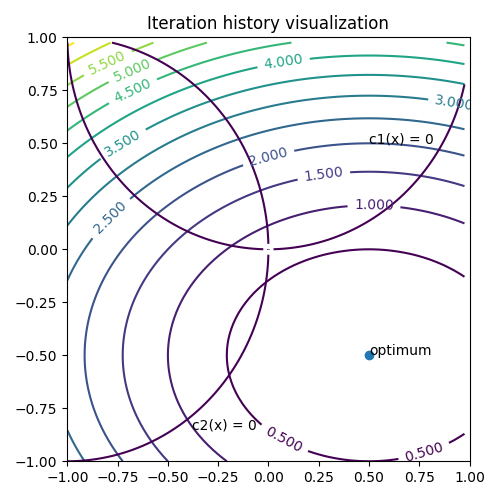

In [10]:
visual_prob(obj_P1, c_P1, 0.5, -0.5)

In [11]:
# optimization settings
max_its = 10
ini_line_step = 0.3
ini_late_step = 1e-1
min_late_step = 1e-3
method = "descent"
info = 100 # this is just for value initialization

# Trial 1 (start from an infeasible point)
x_init = np.asarray([0.2, 0.5])

# run the optimization
it_hist, obj_hist, info = ISO_method(obj_P1, c_P1, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method)

# show the results (The optimization quit at the very beginning)
print('Trial 1: start from an infeasible point')
print_results(info, it_hist, obj_hist)

# Trial 2 (start from a feasible point)
x_init = np.asarray([0.2, 0])

# run the optimization
it_hist, obj_hist, info = ISO_method(obj_P1, c_P1, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method)

# show the results (Visualization is done in the next cell)
print()
print('Trial 2: start from a feasible point')
print_results(info, it_hist, obj_hist)

Trial 1: start from an infeasible point
exit info: -1
iteration history:
[]
objective history:
[]

Trial 2: start from a feasible point
exit info: 0
iteration history:
[array([ 0.2,  0. ]), array([ 0.38, -0.6 ]), array([ 0.452, -0.48 ]), array([ 0.4808, -0.504 ]), array([ 0.49232, -0.4992 ]), array([ 0.496928, -0.50016 ]), array([ 0.4987712, -0.499968 ]), array([ 0.49950848, -0.5000064 ]), array([ 0.49980339, -0.49999872]), array([ 0.49992136, -0.50000026]), array([ 0.49996854, -0.49999995])]
objective history:
[0.58999999999999997, 0.034399999999999986, 0.003104, 0.00040063999999999985, 6.0262400000000387e-05, 9.4883840000001491e-06, 1.5119974400000774e-06, 2.4167383040002168e-07, 3.8657982463994857e-08, 6.1848839782409047e-09, 9.8956570787715536e-10]


<IPython.core.display.Javascript object>


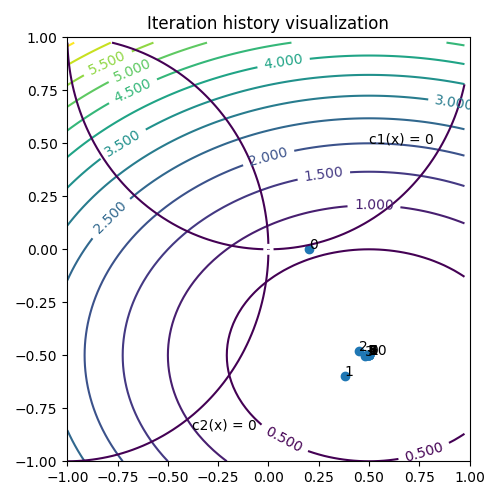

In [12]:
# visualization of the iteration history in the trial 2 above
visual_opt_hist(obj_P1, c_P1, it_hist)

### Problem #2: some active constraint at the optimal point
This test problem is formulated below. The optimal solution [-0.21, -0.61] (approx.) to the problem activate one constraint.

$$
\min: f (x) = (x_1+0.5)^2+2(x_2+0.5)^2 \\
\ s.t. -1 \leq x_1, x_2 \leq 1 \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \\
\     \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \mathbf{c}(x) = \begin{bmatrix} -[(x_1+1)^2+x_{2}^2-1] \\
\     -[x_{1}^2+(x_2-1)^2-1] \end{bmatrix} \leq 0 \\
$$

In [13]:
# problem #2 definition
def obj_P2(x):
    return obj_quad(x, [-0.5, -0.5], 2)

def c_P2(x):
    return c_quad(x, [-1, 0], [0, 1], [-1, -1], [1, 1])

<IPython.core.display.Javascript object>


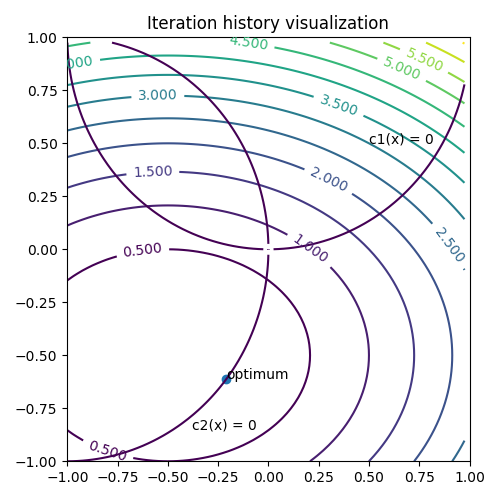

In [14]:
# visualization of the problem
visual_prob(obj_P2, c_P2, -0.21, -0.61)

In [15]:
# optimization settings
max_its = 20
ini_line_step = 0.5
ini_late_step = 1e-1
min_late_step = 1e-3
method = "descent"
info = 100 # this is just for value initialization

# Trial 1 (using steepest descent method)
x_init = np.asarray([0.2, 0])

# run the optimization
it_hist, obj_hist, info = ISO_method(obj_P2, c_P2, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method)

# show the results (The optimization quit at the very beginning)
print('Trial 1: using steepest descent method')
print_results(info, it_hist, obj_hist)

Trial 1: using steepest descent method
exit info: 2
iteration history:
[array([ 0.2,  0. ]), array([-0.5, -1. ]), array([-0.5  , -0.875]), array([-0.40625 , -0.828125]), array([-0.31930161, -0.77473501]), array([-0.25876823, -0.68262124]), array([-0.1956175 , -0.61157098]), array([-0.22947356, -0.64714903]), array([-0.17736132, -0.56953996]), array([-0.19214434, -0.58960721]), array([-0.22171654, -0.62866804]), array([-0.20589654, -0.60945123]), array([-0.22191387, -0.62849416]), array([-0.20609896, -0.60927331]), array([-0.21411731, -0.61883798]), array([-0.2064131 , -0.60901264]), array([-0.21414509, -0.61881553]), array([-0.20644128, -0.60898987]), array([-0.2141727 , -0.61879321]), array([-0.2064693 , -0.60896723]), array([-0.21420015, -0.61877102]), array([-0.20649715, -0.60894473])]
objective history:
[0.98999999999999999, 0.5, 0.28125, 0.22412109375000003, 0.18361055556514935, 0.12489380011982562, 0.11754487401230834, 0.11649022695287711, 0.11376732952300703, 0.11083400901359163

<IPython.core.display.Javascript object>


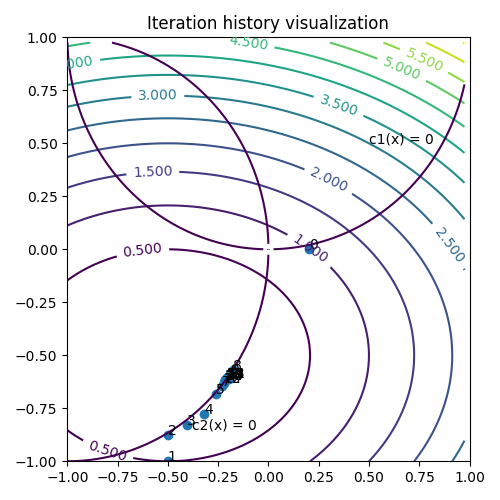

In [16]:
# visualization of the trial 1 above
visual_opt_hist(obj_P2, c_P2, it_hist)

In [17]:
# Trial 2 (using Newton's method)
method = "Newton"
x_init = np.asarray([0.2, 0])

# run the optimization
it_hist, obj_hist, info = ISO_method(obj_P2, c_P2, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method)

# show the results (Visualization is done in the next cell)
print("Trial 2: using Newton's method")
print_results(info, it_hist, obj_hist)

Trial 2: using Newton's method
exit info: 1
iteration history:
[array([ 0.2,  0. ]), array([ 0.025, -0.125]), array([ 0.03105779, -0.22205296]), array([-0.04747602, -0.34334743]), array([-0.05423357, -0.43486938]), array([-0.14463856, -0.52314134]), array([-0.2003594 , -0.60701586]), array([-0.18828279, -0.58599548]), array([-0.20270115, -0.60704181]), array([-0.21951856, -0.62633449]), array([-0.20510781, -0.60691802]), array([-0.20891899, -0.61192309]), array([-0.21286929, -0.61682043]), array([-0.20906668, -0.61191792]), array([-0.21002831, -0.61315285]), array([-0.20907587, -0.61191767])]
objective history:
[0.98999999999999999, 0.55687500000000001, 0.43653149905620814, 0.2538580069047538, 0.20719170470664977, 0.12735279466856275, 0.1126892785230616, 0.11195806575046491, 0.111302505513071, 0.11059064407900754, 0.10982433332837878, 0.10978170958005387, 0.10973807365109808, 0.10969343672183912, 0.10969071644309145, 0.10968797998101269]


<IPython.core.display.Javascript object>


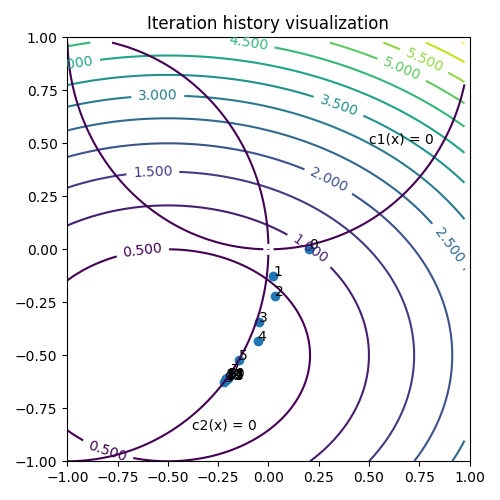

In [18]:
# visualization of the trial 2 above
visual_opt_hist(obj_P2, c_P2, it_hist)

### Problem #3: multiple active constraints at the optimal point
This test problem is formulated below. The optimal solution [-0.0, -0.0] to the problem activate multiple constraints.


$$
\min: f (x) = (x_1+0.5)^2+3(x_2-0.5)^2 \\
\ s.t. -1 \leq x_1, x_2 \leq 1 \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \\
\     \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \mathbf{c}(x) = \begin{bmatrix} -[(x_1+1)^2+x_{2}^2-1] \\
\     -[x_{1}^2+(x_2-1)^2-1] \end{bmatrix} \leq 0 \\
$$

In [19]:
# problem #3 definition
def obj_P3(x):
    return obj_quad(x, [-0.5, 0.5], 3)

def c_P3(x):
    return c_quad(x, [-1, 0], [0, 1], [-1, -1], [1, 1])

<IPython.core.display.Javascript object>


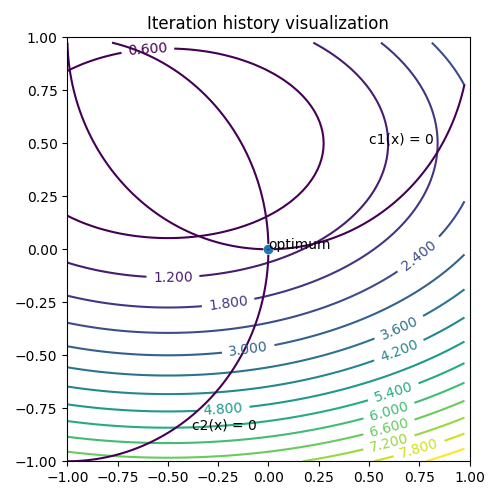

In [20]:
# visualization of the problem
visual_prob(obj_P3, c_P3, 0, -0)

In [21]:
# optimization settings
max_its = 20
ini_line_step = 0.5
ini_late_step = 1e-1
min_late_step = 1e-3
method = "descent"
info = 100 # this is just for value initialization

# Trial 1 (using steepest descent method)
x_init = np.asarray([0.75, 0.25])

# run the optimization
it_hist, obj_hist, info = ISO_method(obj_P3, c_P3, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method)

# show the results
print('Trial 1: using steepest descent method')
print_results(info, it_hist, obj_hist)

Trial 1: using steepest descent method
exit info: 1
iteration history:
[array([ 0.75,  0.25]), array([ 0.7109375,  0.2734375]), array([ 0.62567929,  0.21565039]), array([ 0.54863673,  0.15301492]), array([ 0.46290231,  0.10163644]), array([ 0.37120434,  0.06051021]), array([ 0.27546397,  0.02856653]), array([ 0.17703303,  0.00484108]), array([ 0.0768815 , -0.01147681]), array([ 0.12307413,  0.00756559]), array([ 0.02263823, -0.00639133]), array([ 0.03393637, -0.00085324]), array([ 0.00838581, -0.00325674]), array([ 0.01405789, -0.00052794]), array([ 0.00125078, -0.00162006]), array([ 0.00409254, -0.00026583]), array([ 0.00088548, -0.00052657]), array([  2.36002872e-03,  -9.25567025e-06]), array([ 0.00075612, -0.00013887])]
objective history:
[1.75, 1.620361328125, 1.5097179821536522, 1.4608349321089575, 1.4032614374787031, 1.3384508129737362, 1.2680929121331181, 1.193920811129765, 1.1176178430721668, 1.1156963337257544, 1.042447265689044, 1.0376499618460224, 1.0182581735262581, 1.01584

<IPython.core.display.Javascript object>


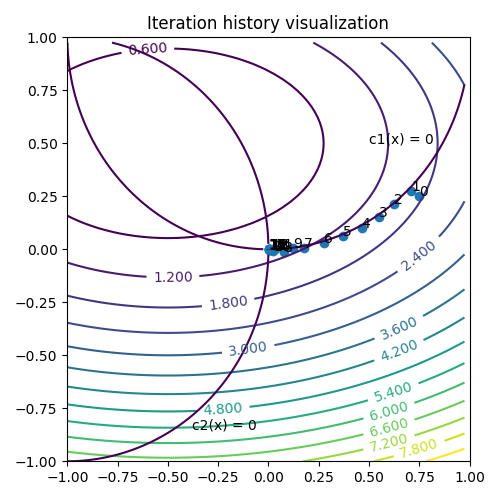

In [22]:
# visualization of the trial 1 above
visual_opt_hist(obj_P3, c_P3, it_hist)

In [23]:
# Trial 2 (using Newton's method)
method = "Newton"
x_init = np.asarray([0.75, 0.25])

# run the optimization
it_hist, obj_hist, info = ISO_method(obj_P3, c_P3, x_init, max_its, ini_line_step, ini_late_step, min_late_step, method)

# show the results (Visualization is done in the next cell)
print()
print("Trial 2: using Newton's method")
print_results(info, it_hist, obj_hist)


Trial 2: using Newton's method
exit info: 1
iteration history:
[array([ 0.75,  0.25]), array([ 0.7109375,  0.2578125]), array([ 0.62325393,  0.18231123]), array([ 0.67867089,  0.2604483 ]), array([ 0.59140597,  0.18522133]), array([ 0.49391254,  0.12179934]), array([ 0.38998307,  0.06978418]), array([ 0.28241893,  0.02823426]), array([ 0.17318644, -0.00389305]), array([ 0.04547043, -0.01053808]), array([ 0.06457596,  0.00177245]), array([ 0.00971086, -0.00783447]), array([ 0.03315871,  0.00034159]), array([  1.64171549e-03,  -9.82292093e-05]), array([  3.77464903e-05,  -4.71491690e-04])]
objective history:
[1.75, 1.642333984375, 1.5644778436772964, 1.5614201216505159, 1.4884238215337882, 1.4169693467861848, 1.347326830952174, 1.2798681342039677, 1.2149046038503921, 1.0794853788800958, 1.0634380886542081, 1.0334927064123871, 1.0332337818079542, 1.0019391272966609, 1.0014528898983581]


<IPython.core.display.Javascript object>


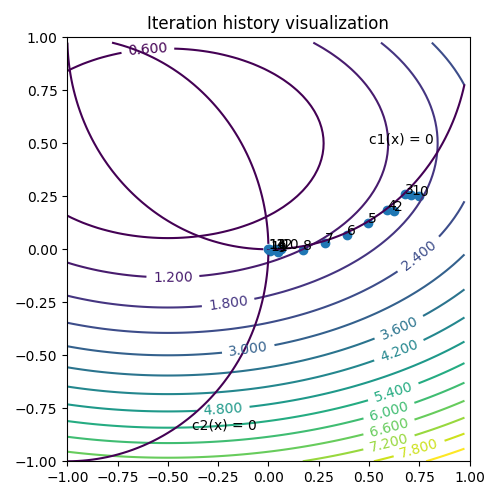

In [24]:
# visualization of the trial 2 above
visual_opt_hist(obj_P3, c_P3, it_hist)

## 4. Conclusion
In this project, a proposed algorithm for solving constrained optimization problems is implemented in Python. Three case problems are solved to showcase the effectiveness of the proposed algorithm. In solving the case problems, the proposed algorithm does not rely on the smoothness of the constrained functions, but always succeeded in finding the local (also global due to the problem formulation) optimal point as long as the starting point is a feasible one. The developed package can be used to solve other problems whose constraint functions are ill-conditioned and whose objective functions are smooth. For example, RBDO problems typically fall into this category.